# Acoustics equations with ExaHyPE 2 and the ClawPack Riemann solvers
 
A very simple solver of an acoustics equation benchmark. The interesting thing here (compared to Euler) is that we use ClawPack's point-wise Riemann solver for this problem.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "acoustics"], "exaclaw" )

## The simplest ExaClaw Finite Volumes solver

Our first step is to use a Finite Volumes solver. We refer them as ExaClaw solvers. ExaClaw is the research project, where we promised to marry ExaHyPE and ClawPack's Riemann solvers. The actual softare is still ExaHyPE + ClawPack. The ClawPack solver is similar to the Euler one. Instead of a (generic) flux and eigenvalue, it needs the name of the ClawPack Riemann solver plus the Fortran file with the implementation. The latter actually can be a set of Fortran files for more complex solvers.

In [4]:
patch_size     = 11
unknowns       = 2
auxiliary_variables = 2 
time_step_size = 0.0001
max_h          = 0.1
min_h          = 0.1


# This is where the Fortran file is located:
# /home/tobias/git/clawpack/riemann/src/rp1_acoustics_variable_ptwise.f90


my_solver = exahype2.solvers.fv.PointWiseClawPackFixedTimeStepSize(
  "Acoustics", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
  "rp1_ptwise", 
  ["/home/tobias/git/clawpack/riemann/src/rp1_acoustics_variable_ptwise.f90"]
)
project.add_solver( my_solver )

The two fundamental pieces of info we still have to feed into the solver are proper boundary and initial conditions. I use some factory/symbolic mechanisms here for the boundary conditions. For the initial condition, I could just omit the parameter. I'd then get a file Acoustic.cpp with an empty function that I have to implement. As this function will be close to trivial once more, I directly inject the C++ code here. So I don't have to touch any C++ code while I run the Juptyer notebook.

In [5]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=2,auxiliary_variables=2,dimensions=2)

my_solver.set_implementation(
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC(),
  initial_conditions="""
   Q[0] = (volumeCentre(0)-0.5)*(volumeCentre(0)-0.5) + (volumeCentre(1)-0.5)*(volumeCentre(1)-0.5) < 0.1*0.1 ? 0.2 : 0.1;
   Q[1] = 0.1;
   Q[2] = 0.1; // first aux variable
   Q[3] = 0.1; // first aux variable
  """
)   


## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [6]:
#build_mode = peano4.output.CompileMode.Asserts
build_mode = peano4.output.CompileMode.Release

dimensions = 2

end_time = 0.005
    
project.set_global_simulation_parameters(
  2,                        # dimensions
  [0.0,0.0],  [1.0,1.0],
  end_time,                 # end time
  0.0, time_step_size*10    # snapshots
)

## Generate a Peano 4 project

This is exactly the same as for Euler: We ask the ExaHyPE 2 frontend to give us a Peano project.

In [7]:
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran


A "big" difference to Euler is that we now have some external Fortran files. Usually, we take the default settings when we invoke the Fortran compiler. Default is the stuff given to us by Peano's configure. There's however the opportunity to add further flags manually. I use this here to inject debug info.

In [8]:
peano4_project.output.makefile.add_Fortran_flag( "-g" )
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated exaclaw-main.cpp
write ./Makefile
write ././AbstractAcoustics.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.h)
write ././AbstractAcoustics.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/AcousticsQ.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.h.template)
write ./celldata/AcousticsQ.cpp (generated from template /home/tobias/git/Peano

In [9]:

parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o AbstractAcoustics.o AbstractAcoustics.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o Acoustics.o Acoustics.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o observers/SolverRepository.o observers/SolverRepository.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o celldata/AcousticsQ.o celldata/AcousticsQ.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o facedata/AcousticsQ.o facedata/AcousticsQ.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o facedata/AcousticsQNew.o facedata/AcousticsQNew.cpp
g++ -std=c++0x -O2 -DPeanoDebug=0 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o faceda

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [10]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
 1768618539   00:00:01     rank:0       core:9       warning      tarch::logging::Statistics::writeToCSV(string)          no statistics available. Recompile with -DTrackStatistics for runtime sampling (file:tarch/logging/Statistics.cpp,line:142)

run completed without error code, but check for warnings and numerical assertions/errors


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [11]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
h_min=0.037037
triggered plot at 0.096846431s
started new time step at 0.203604174s
started new time step at 0.224255606s
started new time step at 0.244783625s
started new time step at 0.26555043s
started new time step at 0.286145757s
started new time step at 0.30684751400000004s
started new time step at 0.327287589s
started new time step at 0.347711366s
started new time step at 0.368185715s
started new time step at 0.39032080099999994s
triggered plot at 0.411095985s
started new time step at 0.5177838309999999s
started new time step at 0.5382734269999999s
started new time step at 0.5588213009999999s
started new time step at 0.579343088s
started new time step at 0.599952905s
started new time step at 0.620308447s
started new time step at 0.640742092s
started new time step at 0.661040958s
started new time step at 0.6833813129999999s
started new time step at 0.703654904s
triggered plot at 0.72434151s
started new time step at 0.829909756s
started new time step at 0.85021166

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

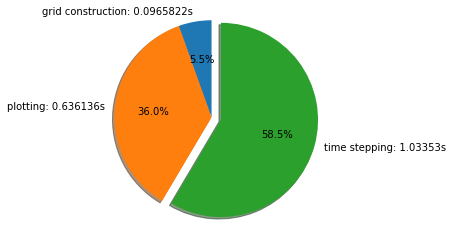

In [12]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

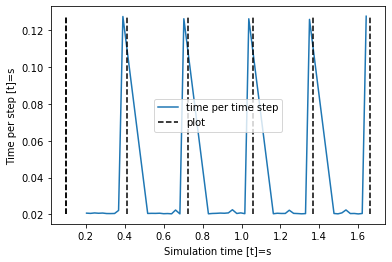

In [13]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

We first do an ls on our directory and search for the root .peano-patch-file. I then convert this file manually into vtu which I can load into Paraview. This works if Peano is configured with vtk support. If you don't have vtk support in there, then you might want to load the data directly into Paraview through Peano's Paraview plug-in.

In [14]:
!ls

AbstractAcoustics.cpp  exahype.log-filter
AbstractAcoustics.h    facedata
AbstractAcoustics.o    Makefile
Acoustics	       observers
acoustics.avi	       output.txt
Acoustics.cpp	       peano4
Acoustics.h	       solution-Acoustics.peano-patch-file
Acoustics.ipynb        solution-Acoustics-tree-0-0.peano-patch-file
Acoustics.o	       solution-Acoustics-tree-0-1.peano-patch-file
celldata	       solution-Acoustics-tree-0-2.peano-patch-file
Constants.h	       solution-Acoustics-tree-0-3.peano-patch-file
convert		       solution-Acoustics-tree-0-4.peano-patch-file
exaclaw-main.cpp       solution-Acoustics-tree-0-5.peano-patch-file
exaclaw-main.h	       vtk-output
exaclaw-main.o


### Explicit conversion

This is the explicit, one-off conversion via the postprocessing tool:

In [15]:
import peano4.visualisation

peano_output_files = "solution-Acoustics"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()


inspect file solution-Acoustics ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-Acoustics.peano-patch-file']
found selectors {'AcousticsQ'}
extract fine grid from solution-Acoustics ... 
inspect file solution-Acoustics ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-Acoustics.peano-patch-file']
found selectors {'AcousticsQ', 'AcousticsQ-fine-grid'}
convert file solution-Acoustics into vtk (vtu binary format) ... 


Now you can invoke Paraview or VisIt in a separate window and study the outcome.

## Running in parallel

In line with the Euler example, adding parallelim is not too hard:

In [16]:
if build_mode == peano4.output.CompileMode.Release:
  end_time = 1.0

project.set_global_simulation_parameters(
  2,                        # dimensions
  [0.0,0.0],  [1.0,1.0],
  end_time,                 # end time
  0.0, end_time/100         # snapshots
)

project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision" )

# We might have changed the build mode, so we reparse the Peano setup again
project.set_Peano4_installation("../../..", build_mode)
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran
generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated exaclaw-main.cpp
write ./Makefile
write ././AbstractAcoustics.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.h)
write ././AbstractAcoustics.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/AcousticsQ.h (generated from template /home/tobias/git/Peano/p

In [ ]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

In [ ]:
#import peano4.visualisation
#
#peano_output_files = "solution-Acoustics"
#convert = peano4.visualisation.Convert( peano_output_files, True )
#convert.set_visualisation_tools_path( "../../../src/convert" )
#convert.extract_fine_grid()
#convert.convert_to_vtk()


It happened to me that the lines above fail within a notebook. My guess is that the memory demands simply are too high. If this is the case, you might want to type in

<pre>
mkdir vtk-output
rm vtk-output/*
../../../src/convert/convert apply-filter solution-Acoustics.peano-patch-file AcousticsQ vtk-output extract-fine-grid AcousticsQ-fine-grid
../../../src/convert/convert convert-file vtk-output/solution-Acoustics.peano-patch-file AcousticsQ-fine-grid vtk-output vtu
</pre>
